# Recuperación de Oro

## Proceso tecnológico

¿Cómo se extrae el oro del mineral? El mineral extraído se somete a un tratamiento primario para obtener la mezcla de mineral, o alimentación rougher, que es la materia prima utilizada para la flotación (también conocida como proceso rougher). Después de la flotación, el material se somete al proceso de purificación en dos etapas.

1. Flotación

- La mezcla de mineral de oro se introduce en las plantas de flotación para obtener un concentrado de oro rougher y colas rougher (es decir, residuos del producto con una baja concentración de metales valiosos).

- La estabilidad de este proceso se ve afectada por la volatilidad y el estado físico-químico desfavorable de la pulpa de flotación (una mezcla de partículas sólidas y líquido).

2. Purificación

- El concentrado rougher se somete a dos etapas de purificación. Tras esto, tenemos el concentrado final y las nuevas colas.

En este proyecto necesitamos predecir los valores de recuperación del concentrado Rougher y la recupeación final del concentrado, que ayuden a la optimización el proceso de recuperacion de oro.

In [1]:
# importamos la librerías que vamos a usar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


## Carga de datos para su análisis

In [2]:

# cargamos el dataset de entrenamiento y los analizamos

gold_recovery_train = pd.read_csv('./datasets/gold_recovery_train.csv')
#gold_recovery_train.info()
#print(gold_recovery_train.head())


# cargamos el dataset de prueba y los analizamos

gold_recovery_test = pd.read_csv('./datasets/gold_recovery_test.csv')
#gold_recovery_test.info()
#print(gold_recovery_test.head())



In [3]:
# Según la documentación,  hay diferencias de columnas entres el data set de entrenamiento y el dataset de prueba
# Así que vamos a analizar las diferencias y así identificar las que usaremos en el proyecto

# Columnas que tiene el train pero NO el test
cols_solo_train = gold_recovery_train.columns.difference(gold_recovery_test.columns)
print("Columnas exclusivas de TRAIN:")
print(cols_solo_train.tolist())

# Columnas que tiene el test pero NO el train (raro, pero revisamos)
cols_solo_test = gold_recovery_test.columns.difference(gold_recovery_train.columns)
print("\nColumnas exclusivas de TEST:")
print(cols_solo_test.tolist())


#print(gold_recovery_train[cols_solo_train].head(10))


Columnas exclusivas de TRAIN:
['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'rougher.output.

## Conclusiones de la exploración de datos

Se oberva que tenemos muchas columasn de diferencia, esto es importante considerar ya que para que nuestro modelo sea consistente
debemos de entrenarlo en conjunto de características que se encuentren en el dataset de validación.

Analizando esas columnas de diferencia las podremos categorízar así:

Columnas exclusivas de TRAIN (no presentes en TEST):

Objetivos:

- rougher.output.recovery
- final.output.recovery

Outputs intermedios y finales:

- rougher.output.*
- primary_cleaner.output.*
- secondary_cleaner.output.*
- final.output.*

Cálculos derivados:
- rougher.calculation.*

Estas columnas no se usan como features, solo para evaluar la calidad del modelo, es por ello que cuando lleguemos a la creación de nuestro modelo predictivo usaremos esta información para entrenar solo sobre las características de interés.


# Confirmemos el valor de la recuperación en los datos

Ahora, dada la fórmula de la recuperación vamos hacer el cálculo manual y compararlo contra el proporcionado en los datos, 
esto con el fin de confirmar la veracidad de la información.

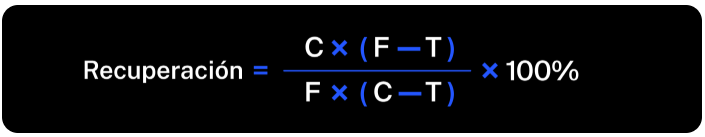


dónde:

- C:
    - Para saber la recuperación del concentrado rougher → la proporción de oro en el concentrado justo después de la flotación o
    - Para saber la recuperación del concentrado final → después de la purificación.
- F:
    - Para saber la recuperación del concentrado rougher → la proporción de oro en la alimentación antes de la flotación
    - Para saber la recuperación del concentrado final → en el concentrado justo después de la flotación.
- T:
    - Para saber la recuperación del concentrado rougher → la proporción de oro en las colas rougher justo después de la flotación.
    - Para saber la recuperación del concentrado final → después de la purificación.


Para predecir el coeficiente, hay que encontrar la proporción de oro en el concentrado y en las colas. Ten en cuenta que tanto el concentrado final como el concentrado rougher tienen importancia.

# Limpieza de datos

Observamos que la fórmula necesita  que la proporción de oro en las colas rougher justo después de la flotación. sea diferente de CERO y que  la proporción de oro en el concentrado justo después de la flotación no sea igual a  la proporción de oro en las colas rougher justo después de la flotación. 

Analizando esto observamos que sí existen un 6% con estas características, que no son nada despreciables pero justo estos datos son necesrios para los cálulos solicitados, así que procederemos a eliminarlos.

In [4]:
# analicemos un conjuto de los datos para este cálculo

#print(gold_recovery_train[['rougher.output.tail_au','rougher.input.feed_au','rougher.output.concentrate_au','rougher.output.recovery']].head(10))

print("Total de valor CERO en el denominador:",len(gold_recovery_train[gold_recovery_train['rougher.input.feed_au'] == 0]))

Total de valor CERO en el denominador: 1159


## Definimos la función de recupeación

In [5]:
# Definifimos la función de cálculo de la recuperación con la fórmula dada


def cal_recovery_rougher(row):
    """
    Función cal_recovery_rougher, para calcular la recupareación después del proceso de flotación
    input: row que es el renglón del dataframe
    output: Fórmula del cálculo de la recuperación dada por los requerimineto
    """
    T = row['rougher.output.tail_au'] #  la proporción de oro en las colas rougher justo después de la flotación.
    F = row['rougher.input.feed_au'] # la proporción de oro en la alimentación antes de la flotación
    C = row['rougher.output.concentrate_au'] #la proporción de oro en el concentrado justo después de la flotación

    if F == 0 or C==T:
        return np.nan
    
    return (C*(F-T)) / (F*(C-T) ) * 100

    

In [6]:
# ahora usamos la fómula paraa aplicarla en el set de dato y validar

gold_recovery_train['recovery_calculated'] = gold_recovery_train.apply(cal_recovery_rougher, axis = 1)

# Antes de limpiar, guarda el tamaño original
print(f"Datos originales: {len(gold_recovery_train)} filas")


# Verificar cuántos NaN hay en la columna calculada
print("NaN en recovery_calculated:", gold_recovery_train['recovery_calculated'].isna().sum())


# Verificar cuántos NaN hay en la columna oficial
print("NaN en rougher.output.recovery:", gold_recovery_train['rougher.output.recovery'].isna().sum())


# Limpiar AMBAS columnas
gold_recovery_train_clean = gold_recovery_train.dropna(subset=['recovery_calculated', 'rougher.output.recovery']).copy()


print(f"Datos después de limpiar ambas columnas: {len(gold_recovery_train_clean)} filas")

# Ahora calcular el MAE
eam = mean_absolute_error(gold_recovery_train_clean['rougher.output.recovery'], 
                         gold_recovery_train_clean['recovery_calculated'])

print("Error absoluto medio (EAM):", eam)


Datos originales: 16860 filas
NaN en recovery_calculated: 2313
NaN en rougher.output.recovery: 2573
Datos después de limpiar ambas columnas: 14287 filas
Error absoluto medio (EAM): 9.303415616264301e-15


## Conclusión de la preparación de datos


- Se observo que el valor *rougher.output.recovery*, que es importante para nuestro objetivo de entrenar un modelo y ver su eficacia, tiene datos Nullo, lo que nos impide usarlo para comparar y verificar nuestra fórmula.

- Se observó que las columnas *rougher.output.tail_au*, *rougher.input.feed_au* y *rougher.output.concentrate_au* tenínan un conlficto matemático entre sus valores lo que ocasionaba un error de cálculo (ZeroDivision), así que estos también fueron eliminados.

- Una vez hecho la limpieza, nos quedamos con el 84.7% de los datos originales.

- Comparando los cálulos manuales, contra los dados en el datase tenemo un EMA de 9.30e-15 lo que nos dice ayuda a confirmar la veracida de los datos proporcionados.

## Análisis de los datos




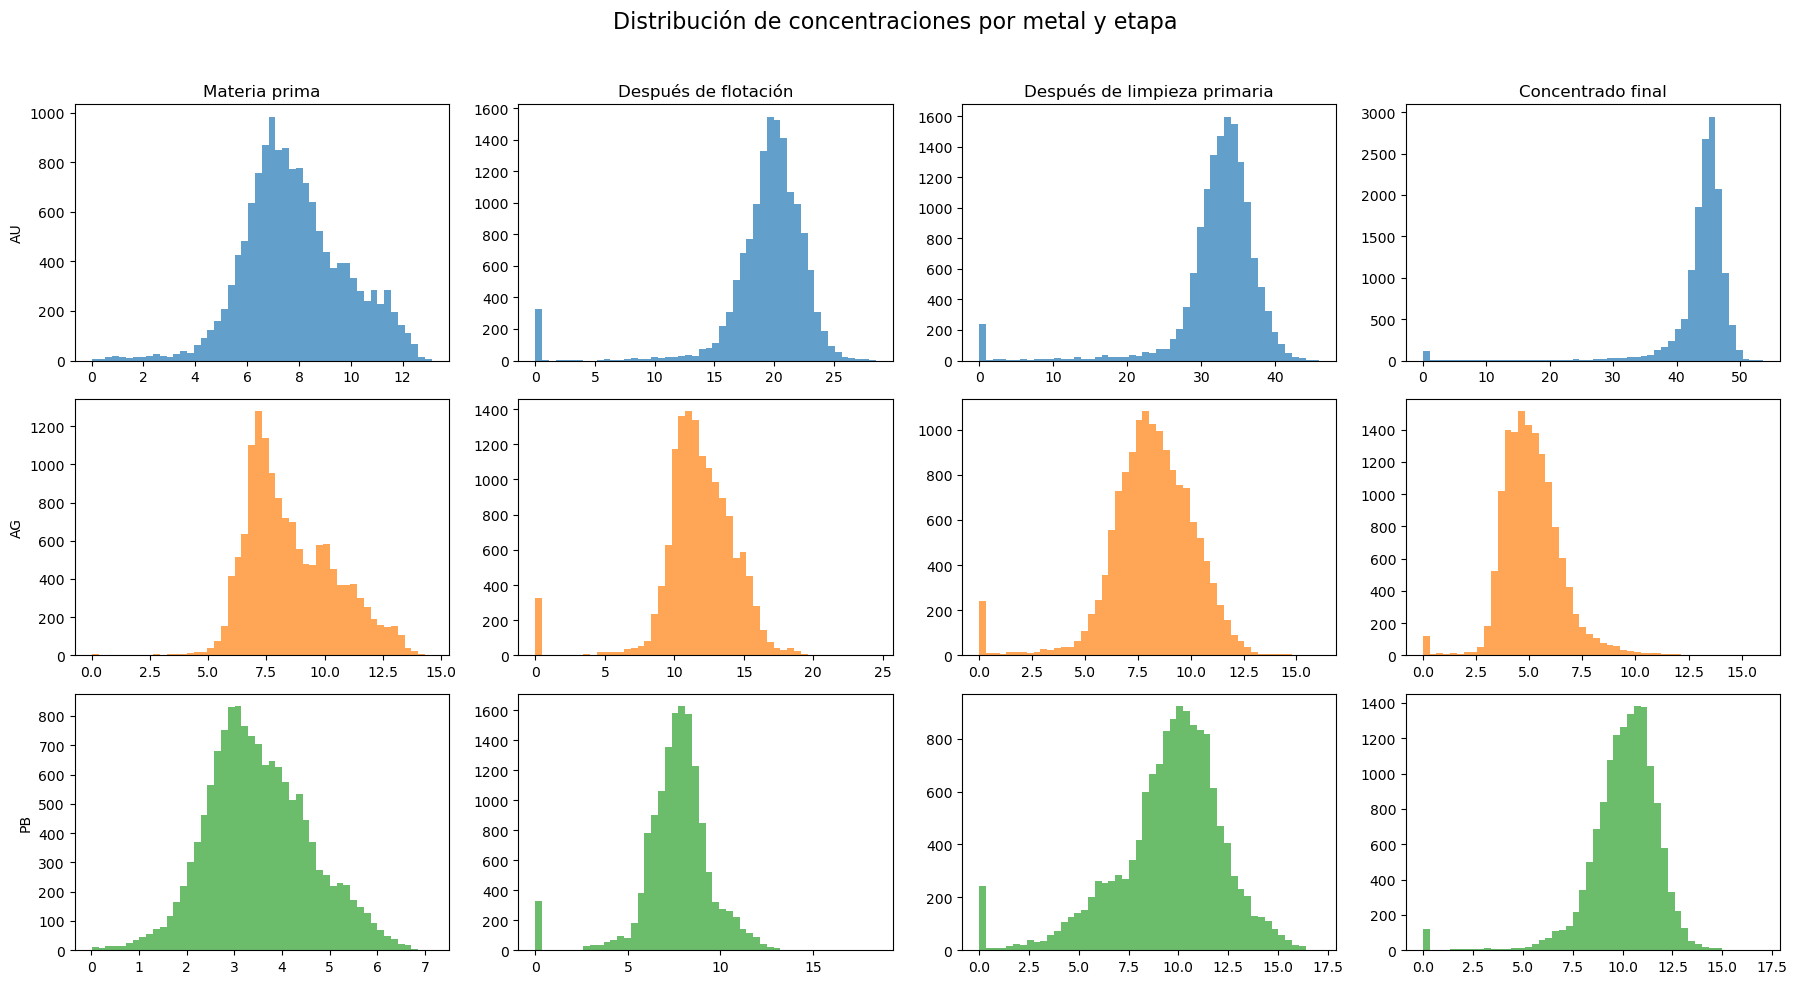

In [7]:

# Definición de etapas
stages = [
    ("rougher.input.feed", "Materia prima"),
    ("rougher.output.concentrate", "Después de flotación"),
    ("primary_cleaner.output.concentrate", "Después de limpieza primaria"),
    ("final.output.concentrate", "Concentrado final")
]

metals = ["au", "ag", "pb"]  # Oro, Plata, Plomo

# Crear figure: filas = metales, columnas = etapas
fig, axes = plt.subplots(len(metals), len(stages), figsize=(18, 10), sharex=False, sharey=False)
fig.suptitle('Distribución de concentraciones por metal y etapa', fontsize=16)

for i, metal in enumerate(metals):       # Filas
    for j, (stage, stage_title) in enumerate(stages):   # Columnas
        col_name = f"{stage}_{metal}"
        if col_name in gold_recovery_train_clean.columns:  # Previene errores si falta una columna
            axes[i, j].hist(gold_recovery_train_clean[col_name], bins=50, alpha=0.7, color='C'+str(i))
            axes[i, j].set_title(stage_title if i == 0 else "")  # Títulos solo arriba
            if j == 0:
                axes[i, j].set_ylabel(metal.upper())  # Etiqueta de fila con nombre del metal

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Se Ajusta para que no se sobreponga con el título
plt.show()

## Distribución de concentraciones por metal por etapa

Como es de esperare, el Oro tiene un incremento de concentración de este con forme se avanza en cada etapa.

el plomo también aumenta su concentración pero en menor medida, y por su parte, la plata disminuye su concentración en con forme avanzan las estapas.

Entrenamiento: count    14138.000000
mean        60.048002
std         22.402317
min          9.659576
25%         48.956411
50%         55.334555
75%         66.036458
max        484.967466
Name: rougher.input.feed_size, dtype: float64
Prueba: count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64


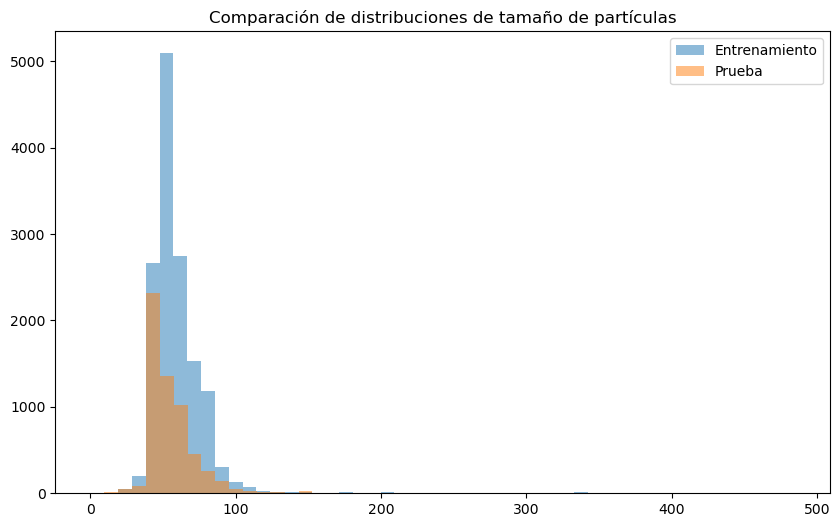

In [8]:

# Histogramas superpuestos
plt.figure(figsize=(10, 6))
plt.hist(gold_recovery_train_clean['rougher.input.feed_size'], alpha=0.5, label='Entrenamiento', bins=50)
plt.hist(gold_recovery_test['rougher.input.feed_size'], alpha=0.5, label='Prueba', bins=50)
plt.legend()
plt.title('Comparación de distribuciones de tamaño de partículas')


# Estadísticas descriptivas
print("Entrenamiento:", gold_recovery_train_clean['rougher.input.feed_size'].describe())
print("Prueba:", gold_recovery_test['rougher.input.feed_size'].describe())

## Distribucion del tamaño de las partículas

Analizando el tamaño de las partículas, observamos que la distribución de se comportan de forma similar tanto en el conjunto de entrenamiento como en le conjunto de pruebas.

Se observan, en ambos casos, una muy ligeras variaciones de outliers, pero son menores así que no se verán afectadas nuestros resultado que obtengamos en el conjunto de entrenamiento.

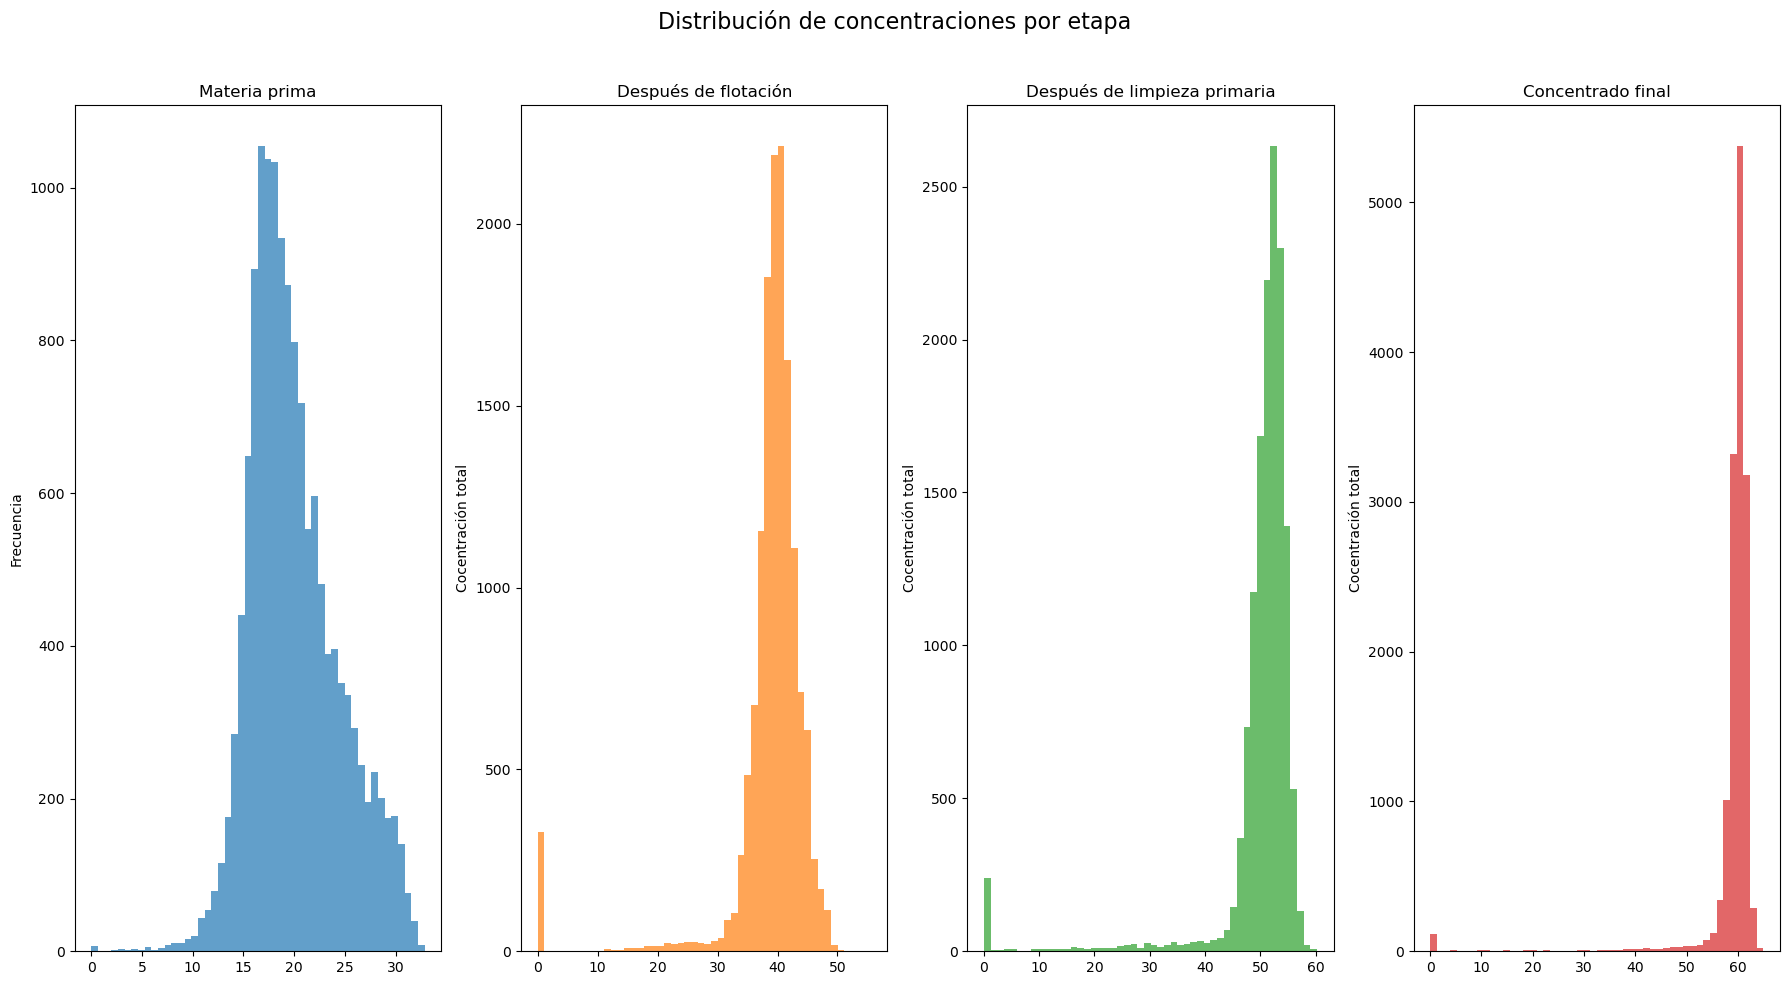

In [9]:
 # vamos a crear la columna que contenga las concentraciones totals de las sustancias en las diferentes etapas
gold_recovery_train_clean['rougher.input.feed.total'] = gold_recovery_train_clean['rougher.input.feed_au']+gold_recovery_train_clean['rougher.input.feed_ag']+gold_recovery_train_clean['rougher.input.feed_pb']
gold_recovery_train_clean['rougher.output.concentrate.total'] = gold_recovery_train_clean['rougher.output.concentrate_au']+gold_recovery_train_clean['rougher.output.concentrate_ag']+gold_recovery_train_clean['rougher.output.concentrate_pb']
gold_recovery_train_clean['primary_cleaner.output.concentrate.total'] = gold_recovery_train_clean['primary_cleaner.output.concentrate_au']+gold_recovery_train_clean['primary_cleaner.output.concentrate_ag']+gold_recovery_train_clean['primary_cleaner.output.concentrate_pb']
gold_recovery_train_clean['final.output.concentrate.total'] = gold_recovery_train_clean['final.output.concentrate_au']+gold_recovery_train_clean['final.output.concentrate_ag']+gold_recovery_train_clean['final.output.concentrate_pb']



# Crear figure: filas = metales, columnas = etapas
fig, axes = plt.subplots(1,len(stages), figsize=(18, 10), sharex=False, sharey=False)
fig.suptitle('Distribución de concentraciones por etapa', fontsize=16)

for j, (stage, stage_title) in enumerate(stages):   # Columnas
    col_name = f"{stage}.total"
    if col_name in gold_recovery_train_clean.columns:  # Previene errores si falta una columna
        axes[j].hist(gold_recovery_train_clean[col_name], bins=50, alpha=0.7, color='C'+str(j))
        axes[j].set_title(stage_title)  # Títulos solo arriba
        axes[j].set_ylabel("Cocentración total")  # Etiqueta de fila con nombre del metal

axes[0].set_ylabel("Frecuencia")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Se Ajusta para que no se sobreponga con el título
plt.show()




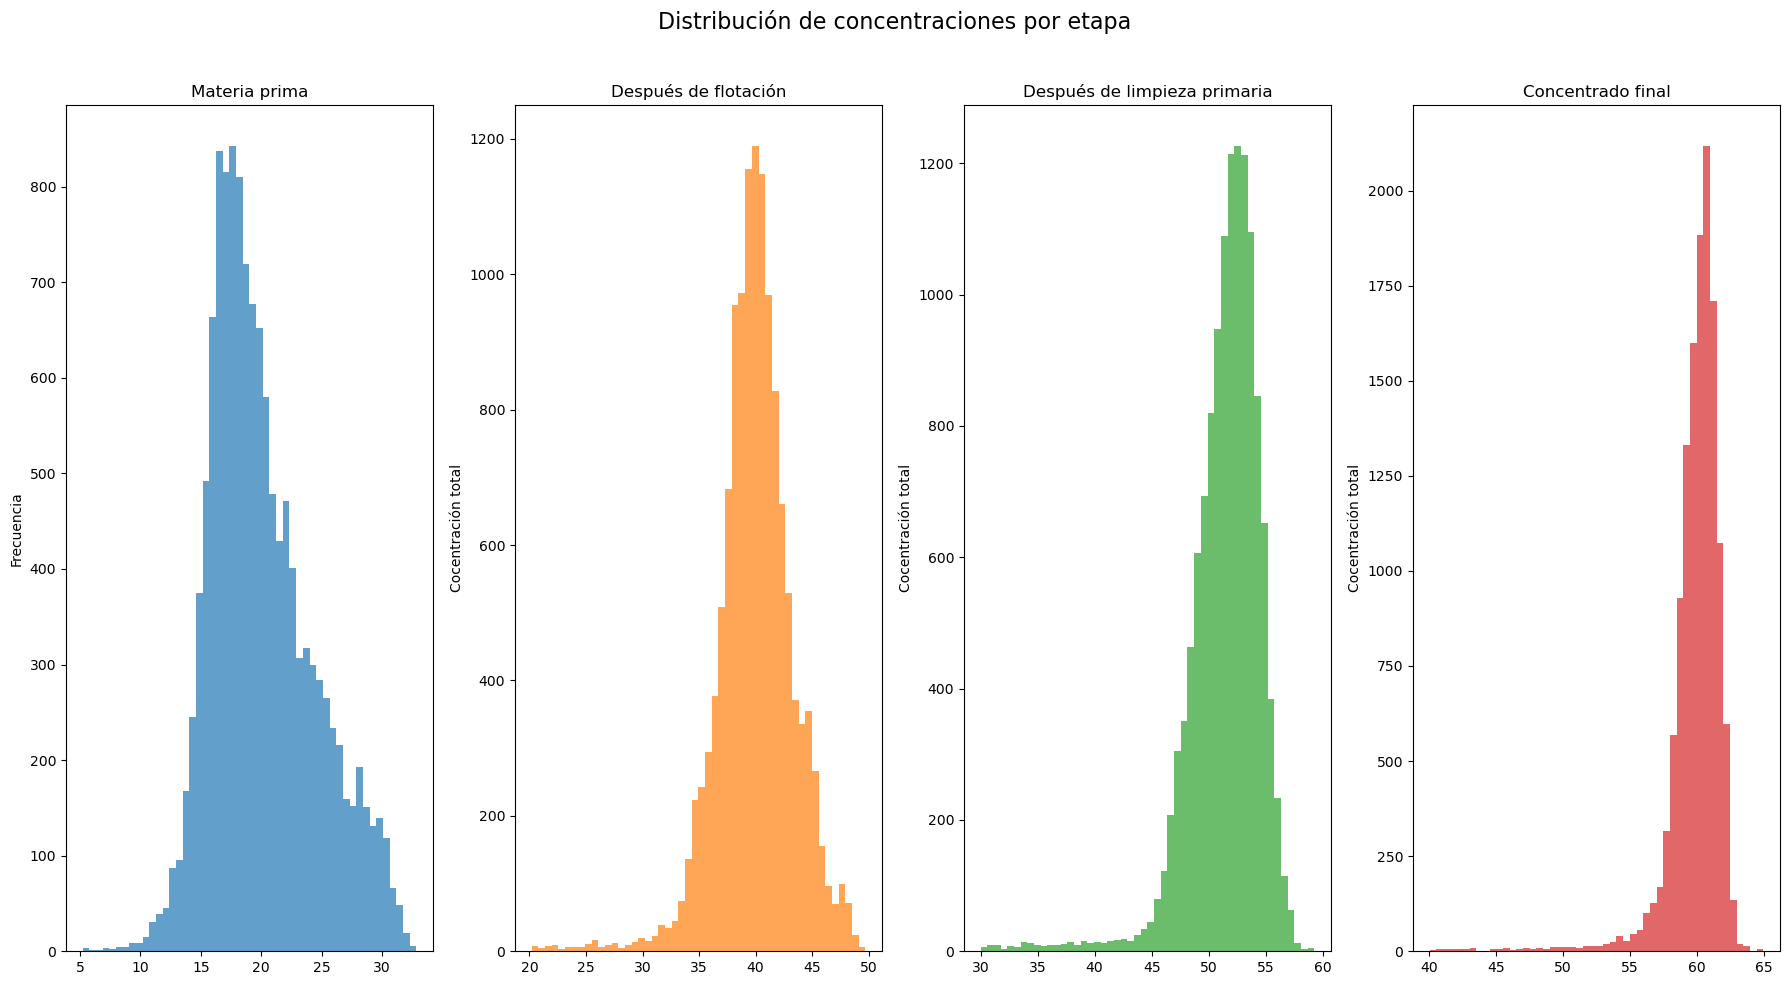

In [10]:
# Vamos a quitar los outliers 


valid_ranges ={
    'rougher.input.feed.total' : (5,35),
    'rougher.output.concentrate.total' : (20,50),
    'primary_cleaner.output.concentrate.total' : (30,60),
    'final.output.concentrate.total' : (40,65),
}

# filtamos los regisotrs fuera de ragno
for col, (low, high) in valid_ranges.items():
    gold_recovery_train_clean = gold_recovery_train_clean.query(f"{low} <= `{col}` <= {high}")


# Crear figure: filas = metales, columnas = etapas
fig, axes = plt.subplots(1,len(stages), figsize=(18, 10), sharex=False, sharey=False)
fig.suptitle('Distribución de concentraciones por etapa', fontsize=16)

for j, (stage, stage_title) in enumerate(stages):   # Columnas
    col_name = f"{stage}.total"
    if col_name in gold_recovery_train_clean.columns:  # Previene errores si falta una columna
        axes[j].hist(gold_recovery_train_clean[col_name], bins=50, alpha=0.7, color='C'+str(j))
        axes[j].set_title(stage_title)  # Títulos solo arriba
        axes[j].set_ylabel("Cocentración total")  # Etiqueta de fila con nombre del metal

axes[0].set_ylabel("Frecuencia")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Se Ajusta para que no se sobreponga con el título
plt.show()



## Concentraciones totales

El sumar las concentraciones de los metales en cada una de las etapas, se observan que se tiene unos outlier, a decir, totales que no son los esperados de concentración ni bajas ni altas. 


Tomamos estos rangos totales de concentración en cada etapa:
- rougher.input.feed.total : (5,35)
- rougher.output.concentrate.total : (20,50)
- primary_cleaner.output.concentrate.total : (30,60)
- final.output.concentrate.total : (40,65)

Y con base a esos rango realizamos el filtrado de los datos.


# Creación de los jnutos de entrenamiento y validación

Dadas las diferencias de datos, vamos a quedarnos con las características que se comparten en el conjunto de entrenamiento y el conjunto de validación, además de eliminar los datos ausente que pueden provorar problemas de cuálculo.

In [11]:

# Dadas las diferencias de datos, vamos a quedarnos con las características que se comparten
# en el conjunto de entrenamiento y el conjunto de validación

# Eliminamos la columna date que no es parte relevante de nuestro caso de investigación
gold_recovery_train_final = gold_recovery_train_clean.drop('date', axis=1)


# Comparamos la columnas entre el conjunto de entrenamiento y el conjunto de validación
features = gold_recovery_train_final.columns.intersection(gold_recovery_test.columns).union(['rougher.output.recovery', 'final.output.recovery'])
features_valid = gold_recovery_train_final.columns.intersection(gold_recovery_test.columns)

#print(features)

# Eliminamos los valores nulo,que como vimos anteriormente, son un conjunto muuy pequeño
gold_recovery_train_final = gold_recovery_train_final[features].dropna()

# Obtnemos el conjunto de entrenamiento
features_train = gold_recovery_train_final.drop(['rougher.output.recovery', 'final.output.recovery'],axis=1)

# Obtenemos los conjutos objetivos para Rougher y Final
target_train_rougher_output_recovery = gold_recovery_train_final['rougher.output.recovery']
target_train_final_output_recovery = gold_recovery_train_final['final.output.recovery']

# En nuestro conjunto de validación (test) eliminamos los nulos y obtenemos el conjunot final para usar
# nuestros mejores modelos
features_valid = gold_recovery_test[features_valid].dropna()




# Creación de la métrica de evaluación sMAPE

Se llama sMAPE, o error medio absoluto porcentual simétrico. Ésta métrica tiene en cuenta la escala tanto del objetivo como de la predicción.

Así es como se calcula el sMAPE:

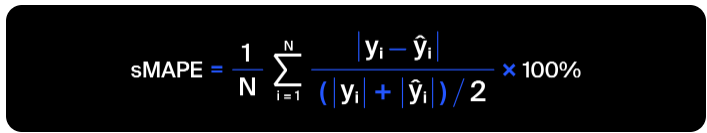

Designación:

 = Valor del objetivo para la observación con el índice i en el conjunto utilizado para medir la calidad.


 = Valor de la predicción para la observación con el índice i, por ejemplo, en la muestra de prueba.

 = Número de observaciones de la muestra.


In [12]:
# Vamos a crear la funcion para calcular el sMAPE 


def sMAPE(real_values, predicted_values):
    real = np.array(real_values)  # convertimos a arreglo los valores
    predicted = np.array(predicted_values) # convertimos a arreglo los valores
    total = len(real) # Total de registros
    suma = 0  # Suma final antes de la división sobre los totales
    for i in range(total):
        if abs(real[i]) + abs(predicted[i]) > 0:  # Si se cumple que el denominador es CERO se omite
            suma += ( (abs(predicted[i] - real[i]) / ((abs(real[i]) + abs(predicted[i]))/2 ) ) ) * 100
    return suma/total # Resultado final


# Para aplicar la validación cruzada usamos la función SMAPE personalizada
def smape_scorer(real_values, predicted_values):
    return sMAPE(real_values, predicted_values)  # función SMAPE


## Definimos el scoring que vamos a usar en todos los modelos.
smape = make_scorer(smape_scorer, greater_is_better=False)


# función para imprimo el tiempo de entrenamiento y decisión decada modelo
def formatear_tiempo(segundos):
    if segundos < 60:
        return f"{segundos:.2f} segundos"
    elif segundos < 3600:
        minutos = segundos // 60
        segundos_restantes = segundos % 60
        return f"{int(minutos)}m {segundos_restantes:.1f}s"
    else:
        horas = segundos // 3600
        minutos = (segundos % 3600) // 60
        return f"{int(horas)}h {int(minutos)}m"


# Entrenamiento de diferentes modelos


Para comenzar a anlizar con qué modelo vamos a tener mejores resultado, haremos una revisión rápida usando; Regresion Lineal y Árbol de Decisión, esto nos va a servir de base para explora más modelos.

Comenzaremos usando el conjunto de entrenamiento (features_train) y el objetivo Rougher(target_train_rougher_output_recovery).

# Modelo de regresión lineal


In [13]:
model = LinearRegression( ) # Creamos el modelo de regresión lineal
# Usamos la validación cruzada con 5 folds
scores = cross_val_score(model, features_train, target_train_rougher_output_recovery, 
                        cv=5, scoring=smape)
print(f"SMAPE promedio con Regresión Lineal: {-scores.mean():.4f}")

SMAPE promedio con Regresión Lineal: 7.0213


# Árbol de decisión

In [14]:
model = DecisionTreeRegressor(random_state=12345) # Creamos el árbol de decisión
#  Usamos la validación cruzada con 5 fols
scores = cross_val_score(model, features_train, target_train_rougher_output_recovery, 
                        cv=5, scoring=smape)

print(f"SMAPE promedio con Árbol de Decisión: {-scores.mean():.4f}")

SMAPE promedio con Árbol de Decisión: 8.0661


# Primeras conclusiones

En primera instancia, la Regresión Lineal (sMAPE=7.02) dió mejores resultado que el árbol de decisión(sMAPE=8.06), pero sabemos que podemos mejorar esto con un bosque aleatorio e incluso con XGBoost.


Como para esos modelos lo mejor es validar los diferentes hiperparámetros, vamos a crear funciones de apoyo.

In [15]:
def search_random_forest_regressor (param_grid, features, target,  cv=5):
    """
    Dado el param_grid, que es un conjunto de hiperparámetros, vamos a crear los modelos de Bosque Aleatorio y
    calcular la media de los sMAPE para encontrar el de menor resultado

    input: param_grid: diccionario con los hiperparámetros a probar
           features: conjunto de características para el modelo
           target: variable objetivo
           cv: número de pliegues para la validación cruzada
    output: mejor sMAPE, mejor n_estimators, mejor max_depth y el modelo
    """
    best_smape_mean = 1000 # Valor inicial alto para encontrar el mínimo
    best_est = 0 # Mejor número de árboles
    best_depth = 0 # Mejor profundidad
    best_model = None # Mejor modelo
    inicio = time.time() ## Registramos el tiempo de inicio
    for n_estimators, max_depth in itertools.product(param_grid['n_estimators'],
                                                    param_grid['max_depth']):
        # Construimos el modelo con los hiperparámetros
        model = RandomForestRegressor(
            random_state = 12345,
            n_estimators = n_estimators,
            max_depth = max_depth
        )

        scores = cross_val_score(model, features, target, cv=cv, scoring=smape) #Realizamos validación cruzada
        smape_mean = -scores.mean() # Negativo porque pusimos greater_is_better=False

        #print(f"smape {smape_mean:.4f} para n_estimators={n_estimators} y max_depth={max_depth}")
        if smape_mean < best_smape_mean: #  Comparamos si tenemos un mejor smape
            best_smape_mean = smape_mean 
            best_est = n_estimators
            best_depth = max_depth
            best_model = model
            print(f"Best  mean smape until now {best_smape_mean:.4f} para n_estimators={best_est} y max_depth={best_depth}")

    fin = time.time() # Registramos el tiempo final
    tiempo_total = fin - inicio  # Calculamos su diferencia
    print(f"Total time: {formatear_tiempo(tiempo_total)}")
    return best_smape_mean, best_est, best_depth, best_model #Retornamos el mejor smape y sus hiperparámetros





In [16]:
# Creamos el grid de hiperparámetros
param_grid ={
    'n_estimators' : list(range(40,51,10)),
    'max_depth' : list(range(5,8))
}

# NOTA: En nuestra investigación usamos un rango de 20 a 100 para n_estimators y 3 a 9 para max_depth, el proceso tardó cerca de los 45min, así que dejé un rango más pequeño, donde vi los mejores resultados para pruebas rápidas

smape_mean_rougher, n_est_rougher,depth_rougher, best_model_rougher_forest = search_random_forest_regressor(
    param_grid, 
    features_train, 
    target_train_rougher_output_recovery
)
print(f"mejor SMAPE promedio: {smape_mean_rougher:.4f}")
print(f"n_est_rougher: {n_est_rougher}")
print(f"depth_rougher: {depth_rougher}")


Best  mean smape until now 5.9547 para n_estimators=40 y max_depth=5
Best  mean smape until now 5.9429 para n_estimators=40 y max_depth=6
Best  mean smape until now 5.8928 para n_estimators=40 y max_depth=7
Best  mean smape until now 5.8678 para n_estimators=50 y max_depth=7
Total time: 4m 23.0s
mejor SMAPE promedio: 5.8678
n_est_rougher: 50
depth_rougher: 7


# Conclusiones con Bosque Aleatorio


Observamos que al varias los hiperparámetros vamos mejorando nuestro valor sMAPE promedio que el mejor es de *5.8678*, mismo que ya es una mejora significativa que el de la Regresion Lineal. 

*NOTA: En nuestra investigación usamos un rango de 20 a 100 para n_estimators y 3 a 9 para max_depth, el proceso tardó cerca de los 45min, así que dejé un rango más pequeño, donde vi los mejores resultados para pruebas rápidas.*

# Entrenando modelos con XGBoost

Ahora vamos el modelo XGBoost que en la literatura nos ha marcado tener mejores resultado. 

Para este modelo, como también tenemos hiperparámetro, y en este caso, tendremos tres; learning_rate, n_estimators y max_depth, crearemos una función de apoyo para encontrar el mejor modelo

In [27]:
def search_xgb_regressor (param_grid, features, target,  cv=5):
    """
    Dado el param_grid, que es un conjunto de hiperparámetros, vamos a crear los modelos de XGBoost y
    calcular la media de los sMAPE para encontrar el de menor resultado

    input: param_grid: diccionario con los hiperparámetros a probar
           features: conjunto de características para el modelo
           target: variable objetivo
           cv: número de pliegues para la validación cruzada
    output: mejor sMAPE, mejor n_estimators, mejor max_depth, mejor learning_rate y el modelo
    """

    best_smape_mean = 1000 # Valor inicial alto para encontrar el mínimo
    best_est = 0 # Mejor número de árboles
    best_depth = 0 # Mejor profundidad
    best_learning = 0 # Mejor tasa de aprendizaje
    inicio = time.time() ## Registramos el tiempo de inicio
    for n_estimators, max_depth,learning_rate in itertools.product(param_grid['n_estimators'],
                                                    param_grid['max_depth'],
                                                                  param_grid['learning_rate']):
        # construimos el modelo con los hiperparámetros
        model = xgb.XGBRegressor(
            random_state = 12345,
            learning_rate=learning_rate,
            n_estimators = n_estimators,
            max_depth = max_depth
        )

        scores = cross_val_score(model, features, target, cv=cv, scoring=smape) #Realizamos validación cruzada
        smape_mean = -scores.mean() # Negativo porque pusimos greater_is_better=False

        #print(f"smape {smape_mean:.4f} para n_estimators={n_estimators} , max_depth={max_depth} y learning_rate={learning_rate}")
        if smape_mean < best_smape_mean: #  Comparamos si tenemos un mejor smape
            best_smape_mean = smape_mean 
            best_est = n_estimators
            best_depth = max_depth
            best_learning = learning_rate
            best_model = model
            print(f"Best mean smape until now {best_smape_mean:.4f} para n_estimators={best_est} , max_depth={best_depth} y learning_rate={best_learning}")

            
    fin = time.time() # Registramos el tiempo final
    tiempo_total = fin - inicio  # Calculamos su diferencia
    print(f"Total time: {formatear_tiempo(tiempo_total)}")
    return best_smape_mean, best_est, best_depth , best_learning, best_model #Retornamos el mejor smape y sus hiperparámetros


In [31]:

# Creamos el grid de hiperparámetros
param_grid ={
    'n_estimators' : list(range(20,101,10)),
    'max_depth' : list(range(3,5)),
    'learning_rate': [0.1]
}



# NOTA: En nuestra investigación usamos un rango de 30 a 100 para n_estimators, 3 a 8 para max_depth y [0.01, 0.1, 0.2] para learning_rate, el proceso tardó más de media hora, así que dejé un rango más pequeño, donde vi los mejores resultados para pruebas rápidas.


smape_mean_rougher, n_est_rougher,depth_rougher, learning , best_model_rougher_xgboost = search_xgb_regressor(
    param_grid, 
    features_train, 
    target_train_rougher_output_recovery
)
print(f"mejor SMAPE promedio con xgboost: {smape_mean_rougher:.4f}")
print(f"n_est_rougher: {n_est_rougher}")
print(f"depth_rougher: {depth_rougher}")
print(f"learning_rougher: {learning}")


Best mean smape until now 5.4794 para n_estimators=20 , max_depth=3 y learning_rate=0.1
Best mean smape until now 5.4176 para n_estimators=30 , max_depth=3 y learning_rate=0.1
Best mean smape until now 5.3703 para n_estimators=40 , max_depth=3 y learning_rate=0.1
Total time: 12.24 segundos
mejor SMAPE promedio con xgboost: 5.3703
n_est_rougher: 40
depth_rougher: 3
learning_rougher: 0.1


## Conclusiones sobre los modelos

Después de diferentes comparaciones de modelos de entrenamiento, y con sus diferentes hyperparámetros se concluye que el modelo de XGBoost da mejores resultados, teniendo como mejor promedio de sMAPE = 5.3703.

Con esta referencia, vamos a usar un rango de hiperparámetros para ahora entrenarcon el target_train_final_output_recovery, para así pode calcular nuestro sMAPE promedio final.


*NOTA: En nuestra investigación usamos un rango de 30 a 100 para n_estimators, 3 a 8 para max_depth y [0.01, 0.1, 0.2] para learning_rate, el proceso tardó más de media hora, así que dejé un rango más pequeño, donde vi los mejores resultados para pruebas rápidas.*



In [34]:

# Usando el mismo grid que se usaron para Rougher, vamos a encontrar los mejoes parametros para Final
smape_mean_final, n_est_final,depth_final, learning_final,best_model_final_xgboost = search_xgb_regressor(
    param_grid, 
    features_train, 
    target_train_final_output_recovery
)
print(f"mejor SMAPE promedio con xgboost: {smape_mean_final:.4f}")
print(f"n_est_final: {n_est_final}")
print(f"depth_final: {depth_final}")
print(f"learning_final: {learning_final}")



#Imprimimosle sMAPE Final
smape_final = 0.25 * smape_mean_rougher + 0.75 * smape_mean_final
print(f"mejor sMAPE final: {smape_final:.4f}")


Best mean smape until now 8.4272 para n_estimators=20 , max_depth=3 y learning_rate=0.1
Best mean smape until now 8.3415 para n_estimators=20 , max_depth=4 y learning_rate=0.1
Total time: 13.18 segundos
mejor SMAPE promedio con xgboost: 8.3415
n_est_final: 20
depth_final: 4
learning_final: 0.1
mejor sMAPE final: 7.5987


# Conclusiones del Proyecto de Recuperación de Oro


Utilizando XGBoost y con una búsqueda de los mejores hipeparámetros tanto para la recuperación del concentrado rougher, como para la recuperación final del concentrado, se obtienes los mejores indicadores para cada uno:

 
sMAPE(Rougher) = 5.3703  (mejor promedio con los hiperparámetros: n_estimators=40 , max_depth=3 y learning_rate=0.1 )

sMAPE(Final) = 8.3415 (mejor promedio conlos hiperparámetro: n_estimators=20 , max_depth=4 y learning_rate=0.1 )

y usando la fórmula para el SMAPE_Final: 

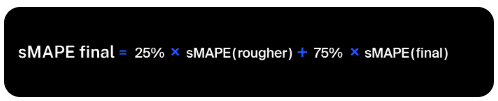


tenemos que

SMAPE_Final = 7.5987


Con lo que concluimos que los modelos best_model_rougher_xgboost y best_model_final_xgboost pueden estimar la recuperación con 
un error promedio relativo de 7.59%, lo cual representa un rendimiento muy satisfactorio para la predicción de recuperación de oro en el proceso de purificación.

Resultados clave:

- Los modelos son capaces de predecir con alta precisión tanto la recuperación del concentrado rougher como la recuperación final.
- Un error del 7.59% indica que las predicciones está nuy cerca de los valores reales.
- Este nivel de precisión es adecuado para la toma de decisión operativas en la planta de procesamiento.

Implicaciones prácticas:

- La empresa puede utilizar estos modelos para optimizar el proceso de recuperacion de oro.
- Las predicciones precisas permiten ajustar parámetros del proceso en tiempo real.

